In [1]:
#############################
### Import libraries ###
#############################

from docplex.cp.model import *
from docplex.cp.config import get_default
import numpy as np
from Solver import *
from User import *
import time

In [2]:
#############################
### Essentials functions ###
#############################
import FunctionMain as fm

In [3]:
# ----------------- Parameters

file = './file_with_optimal_val/la03.txt'

k = 20
nb_layers = 5

display_sol = False
display_start = False
display_matrix = False

tps_max = 200
it_max = 50
it = 1
k_k = 10



In [4]:
#############################
### Main program ###
#############################

print("\n--------Main program is loading...---------")


# --------- Interaction with the solver

data = []

n, m, data, T_machine, T_duration, duration, optimalval = fm.get_data_from_file(file)

# --------- Call Solver constructor in Solver.py and create the variables of the model

model, solver = fm.initialize_solver(data, n, m, duration)

# ------------ Solve the model

print("\nSolving the model...")
msol, nb_solution, runtime = solver.solve(model, k, n, m, 0, T_machine, optimalval)

# ------------ Display the result

fm.display_solution(msol, display_sol)

print("Model solved !")


# ---------------- Interaction with the user



print("\n--------Interaction with the user...---------")

print("\nCreating the user...")
user = User()
print("User created !")

#Get the variables of the model
variables = solver.get_variables()

list_indice, list_obj, pref, list_layers, list_equal = fm.user_preferences(msol, user, nb_layers, optimalval)


# Vector of the start time of each task of each preference
starts = user.start_pref(n, m, variables, display_start)

# Matrix of the start time of each task of each preference
matrix = user.matrix_pref(n, m, display_matrix)

# Testing the order of preferences and the differences between solutions
fm.test(n, m, user)



--------Main program is loading...---------

Creating the model variables...
Model variables created !

Solver initialized !

Solving the model...

Adding precedence constraints to the solver...
Precedence constraints added !

Adding disjunctive constraints to the solver...
Disjunctive constraints added !
Model solved !

--------Interaction with the user...---------

Creating the user...
User created !

Classing solutions...
[696, 734, 696, 696, 734, 734, 696, 728, 696, 701, 696, 696, 696, 696, 696, 728, 696, 701, 734, 701]
Solutions classed !

Creating preferences...
Preferences created !

Testing order of preferences...
	L'ordre des préférences est cohérente

Testing differences between solutions...
	Toutes les solutions sont différentes


In [5]:
####################################################################
#### NOUVELLES SOLUTIONS ET NOUVEAUX CLUSTERING A CHAQUE ITERATION
####################################################################

import clustering as cl

###  -------------- Iteration of the solver with the preferences

it = 1
tps = runtime
list_min_obj = [min(list_obj)]

criterion = (tps < tps_max) and (it < it_max) 

# ----------------- Add the preferences to the model

while criterion :

    print("\n--------Iteration {}---------".format(it))

    it += 1
    
    # --------- Call Solver constructor in Solver.py and create the variables of the model

    model, solver = fm.initialize_solver(data, n, m, duration)

    # --------- Add the new constraints to the model
    variables = fm.update_variables_new_constraint(n, m,  pref, model, solver)
    

# ------------ Solve the model

    print("\nSolving the model...")

    msol, nb_solution, runtime = solver.solve(model, k_k, n, m, it, T_machine, optimalval)

# ------------ Display the result

    fm.display_solution(msol, display_sol)
    
    print("Model solved !")


# ---------------- Interaction with the user

    list_indice, list_obj, pref, list_layers, list_equal = fm.user_preferences(msol, user, nb_layers, optimalval)

    list_min_obj.append(min(list_obj))

    # Vector of the start time of each task of each preference
    starts = user.start_pref(n, m, variables, display_start)

    # Matrix of the start time of each task of each preference
    matrix = user.matrix_pref(n, m, display_matrix)

    # Testing the order of preferences and the differences between solutions
    fm.test(n, m, user)


#------------------ Layers creation  

    layers = cl.create_layers(list_equal, matrix)
    

#------------------Définition du nombre de clusters par layer
    nb_clusters = fm.choose_best_clusters(layers)

    default_value_rayon = 5     # should be a parameter

    for l in range(len(layers)):
        data = layers[l]
        k = nb_clusters[l]

        # print("-------------- Layer", l, "-----------------")

        if(len(data)==1):
            solver.add_constraint(fm.manhattan_distance(data[0], [ model.start_of(variables[i//m][i%m]) for i in range(n*m)]) >= default_value_rayon + 2*l)
            continue
        else :
            k, avg, labels = fm.average_computation(data, k)

            the_ones = fm.solution_average(k, data, labels, avg)
            
            #ajout de contraintes, les solutions doivent etre distantes des centres de clusters, en chaque layer , d'une distance supérieure à 3
            for i in range(k):
                sol_cluster=[]
                for j in range(len(data)):
                    if labels[j]==i:
                        sol_cluster.append(data[j])
                solver.add_constraint(fm.manhattan_distance(the_ones[i],[ model.start_of(variables[i//m][i%m]) for i in range(n*m)]) >=  fm.rayon_cluster(the_ones[i], sol_cluster) + 2*l)
    

#------------------ Condition d'arrêt ------------------

    tps += runtime

    criterion = (tps < tps_max) and (it < it_max)

    fm.stopCondition(it, it_max, tps, tps_max)


--------Iteration 1---------

Creating the model variables...
Model variables created !

Solver initialized !

Solving the model...

Adding precedence constraints to the solver...
Precedence constraints added !

Adding disjunctive constraints to the solver...
Disjunctive constraints added !
Model solved !

Classing solutions...
[734, 734, 696, 734, 701, 696, 696, 696, 728, 701, 696, 696, 696, 696, 696, 696, 696, 696, 696, 696, 696, 701, 701, 701, 728, 728, 734, 734, 734, 734]
Solutions classed !

Creating preferences...
Preferences created !

Testing order of preferences...
	L'ordre des préférences est cohérente

Testing differences between solutions...
	Toutes les solutions sont différentes
Clustering ...

--------Iteration 2---------

Creating the model variables...
Model variables created !

Solver initialized !

Solving the model...

Adding precedence constraints to the solver...
Precedence constraints added !

Adding disjunctive constraints to the solver...
Disjunctive constraint

[696, 696, 696, 696, 696, 696, 696, 696, 696, 696, 696, 696, 696, 696, 696, 696, 696, 696, 696, 696, 696, 696, 696, 696, 696, 696, 696, 696, 696, 696, 696, 696, 696]


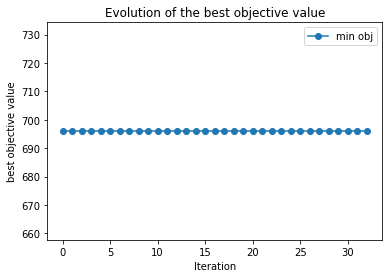

In [6]:
import matplotlib.pyplot as plt
print(list_min_obj)
plt.plot([i for i in range(it)], list_min_obj, label='min obj', marker='o')
plt.xlabel("Iteration")
plt.ylabel("best objective value")
plt.title("Evolution of the best objective value")
plt.legend()
plt.show() 
